# Задача bike-sharing

In [40]:
from sklearn import cross_validation, grid_search, linear_model, metrics

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

In [41]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Загрузка данных

In [42]:
raw_data = pd.read_csv('bike_sharing_demand.csv', header=0, sep=',')

In [43]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**В последнем столбце целевая переменная - количество велосипедов (count). Её и будем прогнозировать.**


***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***casual*** - number of non-registered user rentals initiated

***registered*** - number of registered user rentals initiated

***count*** - number of total rentals

In [44]:
# Посмотрим размер данных
print(raw_data.shape)

(10886, 12)


In [45]:
# Посмотрим, есть ли в выборке пропущенные значения
raw_data.isnull().values.any()

False

# Обработка данных

In [46]:
# Посмотрим тип данных на каждом из столбцов
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [47]:
# Было бы здорово поменять формат у datetime, чтоб применять специфичные для даты-времени операции
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [48]:
raw_data['month'] = raw_data.datetime.apply(lambda x: x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x: x.hour)

In [49]:
# Посмотрим получившийся датафрейм
raw_data.head()
# Видим, что появились столбцы month, year, которые меняют значения в соответствии со временем datetime

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4


# Делим данные на обучение и тест

In [50]:
# Разбиваем данные по времени
train_data = raw_data.iloc[:-1000, :]
test_data = raw_data.iloc[-1000:, :]

In [51]:
print(raw_data.shape, train_data.shape, test_data.shape)
# Видим, что из почти 11 тысяч единиц данных почти 10 тысяч отводится на обучающую выборку

(10886, 14) (9886, 14) (1000, 14)


### Данные и целевая функция

In [52]:
# Обучение
train_labels = train_data['count'].values # Вырежем целевую метку от остальных данных

# Вырежем и эти данные, "поскольку фактически это идентификатор объекта"
train_data = train_data.drop(['datetime', 'count'], axis=1) 

In [53]:
# Тест
test_labels = test_data['count'].values

test_data = test_data.drop(['datetime', 'count'], axis=1)

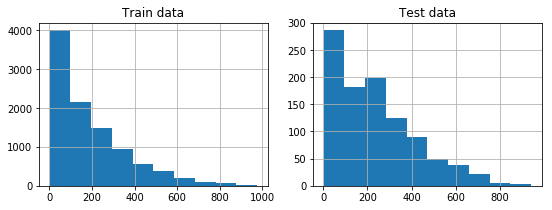

In [54]:
# Визуализируем целевую переменную

plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
plt.hist(train_labels)
plt.title('Train data')
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(test_labels)
plt.title('Test data')
plt.grid()

### Числовые признаки

In [55]:
# Отделим числовые признаки (будем работать только с ними в рамках этого урока)
numeric_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'month', 'hour']

train_data = train_data[numeric_columns]
test_data = test_data[numeric_columns]

In [56]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0.0,3,13,1,0
1,9.02,13.635,80,0.0,8,32,1,1
2,9.02,13.635,80,0.0,5,27,1,2
3,9.84,14.395,75,0.0,3,10,1,3
4,9.84,14.395,75,0.0,0,1,1,4


In [57]:
test_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
9886,17.22,21.210,67,6.0032,20,505,10,7
9887,18.04,21.970,62,0.0000,35,800,10,8
9888,19.68,23.485,55,16.9979,32,323,10,9
9889,20.50,24.240,48,19.0012,65,157,10,10
9890,20.50,24.240,45,27.9993,56,172,10,11


# Обучение модели

In [58]:
# Регрессия на основе стохастического градиентного спуска
regressor = linear_model.SGDRegressor(random_state=0)

In [59]:
regressor.fit(train_data, train_labels)
# Сразу оценим качество на основе среднеквадратичной ошибки
metrics.mean_absolute_error(test_labels, regressor.predict(test_data)) # оценивать качество - на тестовой части данных

12365243430442.309

Какая-то огромная ошибка.     
Посмотрим, как выглядят предсказания, и сравним их с целевой функцией.

In [60]:
# Посмотрим, как выглядит целевая функция
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [61]:
# Посмотрим на предсказания
print(regressor.predict(test_data)[:10])

[ -2.14535112e+13  -3.38186869e+13  -1.68691409e+13  -1.66789074e+13
  -1.51233750e+13  -2.03738397e+13  -2.05013301e+13  -2.33218757e+13
  -2.19390938e+13  -2.57118180e+13]


Предсказываем невероятно большие числа. Так быть не должно.          
Посмотрим на коэффициенты регрессии

In [62]:
regressor.coef_

array([ -9.65054030e+10,   7.81087947e+09,  -1.39397867e+10,
         5.82455708e+10,  -1.62481891e+11,  -3.25073745e+10,
         2.10538607e+10,   1.48871328e+10])

Они тоже огромные.     
Это связано с тем, что признаки сильно отличаются по масштабу. Для того чтобы решить эту проблему, надо отмасштабировать данные с помощью StandardScaler.

# Масштабирование данных

In [63]:
from sklearn.preprocessing import StandardScaler

In [64]:
# Масштабируем признаки
scaler = StandardScaler()
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

### Снова обучаем модель

In [65]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

0.11793762963431514

Ошибка стала очень маленькой.        
Выведем целевую функцию и наши прогнозы.

In [66]:
# Целевая функция
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [67]:
# Прогнозы
print(regressor.predict(scaled_test_data)[:10])

[ 524.82767322  834.83176277  354.85768824  221.89221002  227.84049612
  324.88196372  327.8982227   307.9347954   345.90146969  445.90141764]


Ошибаемся всего на 1 велосипед. **Как-то подозрительно хорошо.**

In [68]:
# Посмотрм на коэффициенты регрессии, чтобы понять прогноз
print(regressor.coef_)

[  1.41019246e+00  -1.40725539e+00   1.45346928e-02  -4.38984175e-02
   5.08589954e+01   1.48004811e+02  -8.23376876e-03   6.37720415e-03]


In [69]:
# Округлим эти коэффициенты до двух знаков после запятой
print(list(map(lambda x: round(x), regressor.coef_)))

[1.0, -1.0, 0.0, -0.0, 51.0, 148.0, -0.0, 0.0]


Практически все признаки принимают маленькие веса за исключением двух.        
Посмотрим на них.

In [70]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0.0,3,13,1,0
1,9.02,13.635,80,0.0,8,32,1,1
2,9.02,13.635,80,0.0,5,27,1,2
3,9.84,14.395,75,0.0,3,10,1,3
4,9.84,14.395,75,0.0,0,1,1,4


Столбец *registered* показывает количество зарегистрированных пользователей, желающих арендовать велосипед.          
Столбец *casual* показывает кол-во НЕзарегистрированных пользователей, желающих арендовать велосипед.

In [71]:
# Выведем значение целевой функции
train_labels[:10]

array([16, 40, 32, 13,  1,  1,  2,  3,  8, 14])

Видим закономерность: если сложить значения столбцов *registered* и *casual*, то получатся значения целевой переменной. Это распространённая ошибка начаинающих data scientist'ов.           
Вырежем эти данные из обучающего набора данных.

In [72]:
train_data.drop(['casual', 'registered'], axis=1, inplace=True)
test_data.drop(['casual', 'registered'], axis=1, inplace=True)

### Снова обучаем модель

In [73]:
# Снова отмасштибруем признаки уже на новом наборе данных
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [74]:
# Обучим модель
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

121.81123864993025

Ошибаемся в среднем на 121 велосипед.

In [75]:
# Выведем веса регрессии
print(list(map(lambda x: round(x), regressor.coef_)))

[31.0, 30.0, -42.0, 6.0, 14.0, 50.0]


# Подбор параметров модели

### Pipeline

In [76]:
from sklearn.pipeline import Pipeline

При кросс-валидации необходимо масштабировать признаки. Получается, надо писать неудобные циклы на каждый fold кросс-валидации. Чтобы этого избежать, придумали Pipeline.

In [77]:
# Создаём Pipeline - первый шаг: масштабирование признаков, второе - обучение модели
pipeline = Pipeline(steps=[('scaling', scaler), ('regression', regressor)]) # steps - список шагов
# Первый элемент - имя шага, второе - объект, который может преобразовывать данные

In [78]:
# Полученную цепочку можно обучить (fit) и получить предсказания (predict)
pipeline.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, pipeline.predict(test_data))

121.81123864993025

Значение предсказания не поменялось --> цепочка работает правильно. Теперь можно подбирать параметры для модели по сетке

### Задание параметров по сетке

In [117]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'scaling', 'regression', 'scaling__copy', 'scaling__with_mean', 'scaling__with_std', 'regression__alpha', 'regression__average', 'regression__epsilon', 'regression__eta0', 'regression__fit_intercept', 'regression__l1_ratio', 'regression__learning_rate', 'regression__loss', 'regression__max_iter', 'regression__n_iter', 'regression__penalty', 'regression__power_t', 'regression__random_state', 'regression__shuffle', 'regression__tol', 'regression__verbose', 'regression__warm_start'])

In [80]:
parameters_grid = {
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss',], # вид функции потерь
    'regression__n_iter' : [3, 5, 10, 50], # количество итераций
    'regression__penalty' : ['l1', 'l2', 'none'], # вид регуляризации
    'regression__alpha' : [0.001, 0.01], # коэффициенты регуляризации
    'scaling__with_mean' : [0, 1], # среднее [для масштабирования]
}

In [81]:
# Строим сетку: передам pipeline, словарь с параметрами, оценивать будем на основе СКО, 
# делать кросс-валидацию на 4 фолда.
grid_cv = grid_search.GridSearchCV(pipeline, parameters_grid, scoring='mean_absolute_error', cv=4)

In [82]:
%%time
grid_cv.fit(train_data, train_labels)

CPU times: user 15.5 s, sys: 3.89 s, total: 19.4 s
Wall time: 12.2 s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=5, n_iter=None, penalty='l2',
       power_t=0.25, random_state=0, shuffle=True, tol=None, verbose=0,
       warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'regression__loss': ['huber', 'epsilon_insensitive', 'squared_loss'], 'regression__n_iter': [3, 5, 10, 50], 'regression__penalty': ['l1', 'l2', 'none'], 'regression__alpha': [0.001, 0.01], 'scaling__with_mean': [0, 1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [83]:
# Смотрим на лучшее значение параметров
print(grid_cv.best_score_, '\n')

# Смотрим на лучшее значение метрики
print(grid_cv.best_params_)

-117.60354611008523 

{'regression__alpha': 0.01, 'regression__loss': 'squared_loss', 'regression__n_iter': 3, 'regression__penalty': 'l2', 'scaling__with_mean': 1}


### Оценим модель по полученным параметрам

In [84]:
metrics.mean_absolute_error(test_labels, grid_cv.best_estimator_.predict(test_data))

121.89713363417185

In [85]:
# Насколько наша ошибка большая относительно среднего значения целевой переменной?
np.mean(test_labels)

232.15899999999999

В среднем у нас 232 велосипеда, а ошибаемся на 122.

**Фактически задание параметров модели по сетке не помогло улучшить модель**.        
Докажем это:

In [86]:
# Получим предсказания
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [87]:
# Выведем правильные значения целевой метки
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [88]:
# Выведем предсказания
print(test_predictions[:10])

[ 128.98707747  148.09567325  194.80937485  224.27837507  244.66958488
  253.06324164  257.89527936  282.19026583  288.82415295  297.94420472]


Для хорошей модели мы ожидаем облако точек в районе диагонали. 

(-100, 1100)

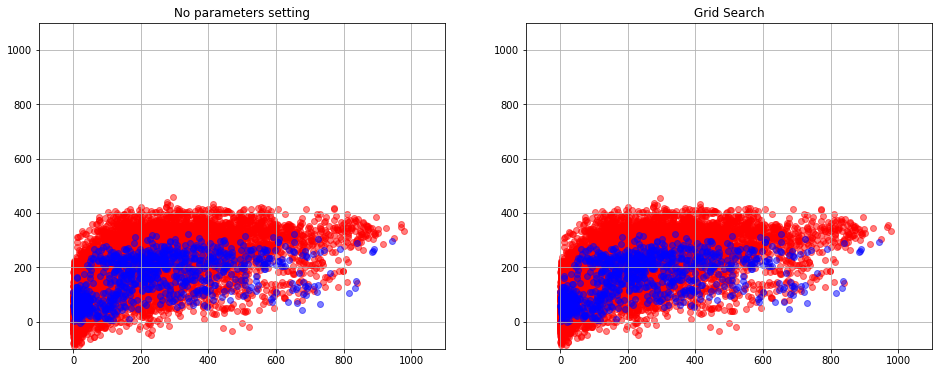

In [89]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.grid()
plt.scatter(train_labels, pipeline.predict(train_data), alpha=0.5, color='red')
plt.scatter(test_labels, pipeline.predict(test_data), alpha=0.5, color='blue')
plt.title('No parameters setting')
plt.xlim(-100, 1100)
plt.ylim(-100, 1100)

plt.subplot(1, 2, 2)
plt.grid()
plt.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color='red')
plt.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color='blue')
plt.title('Grid Search')
plt.xlim(-100, 1100)
plt.ylim(-100, 1100)

Генерального направления не проглядывается --> модель является довольно слабой, и **оптимизация по параметрам ничего не дала**.

# Задача bike-sharing (продолжение)

In [135]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder

In [91]:
raw_data = pd.read_csv('bike_sharing_demand.csv', header=0, sep=',')

In [92]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [93]:
# Было бы здорово поменять формат у datetime, чтоб применять специфичные для даты-времени операции
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)
raw_data['month'] = raw_data.datetime.apply(lambda x: x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x: x.hour)

In [94]:
# Разбиваем данные по времени
train_data = raw_data.iloc[:-1000, :]
test_data = raw_data.iloc[-1000:, :]

In [95]:
print(raw_data.shape, train_data.shape, test_data.shape)
# Видим, что из почти 11 тысяч единиц данных почти 10 тысяч отводится на обучающую выборку

(10886, 14) (9886, 14) (1000, 14)


Разделим данные на признаки и целевую метку. Вырезаем *datetime, count, casual, registered* (последние два -- потому что при их сложении мы получаем целевую переменную).

In [96]:
# train data processing
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis=1)

In [97]:
# test data processing
test_labels = test_data['count'].values
test_data = test_data.drop(['datetime', 'count', 'casual', 'registered'], axis=1)

In [98]:
# Получим индекс бинарных данных: для каждого столбца выводится True, если данные в столбце - бинарные
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype=bool)

In [99]:
print(binary_data_columns)
print(binary_data_indices)

['holiday', 'workingday']
[False  True  True False False False False False False False]


In [100]:
categorical_data_columns = ['season', 'weather', 'month']
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype=bool)

In [101]:
print(categorical_data_columns)
print(categorical_data_indices)

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


In [102]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype=bool)

In [103]:
print(numeric_data_columns)
print(numeric_data_indices)

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


### Pipeline

In [104]:
regressor = linear_model.SGDRegressor(random_state=0, n_iter=3, loss='squared_loss', penalty='l2')

Первый шаг - обработка данных, второй - построение модели.
Построение модели: задаем имя шага и передаем модель (регрессор).

Преобразование данных:
1. Разбить данные (получить 3 набора данных).
2. Каждую категорию обработать.
3. Собрать данные вместе.

Важно! Собирать и разбирать данные надо в одинаковом порядке.

1. Чтобы разбить данные и собрать их вместе, надо использовать трансформер FeatureUnion;
2. Внутри трансформера три части преобразований: с бинарными данными, с числовыми данными, с категориальными;
3. Бинарные данные устраивают - достаточно просто выбрать эти данные и отделить их от остальных данных, не изменяя;
4. Числовые данные надо отделить и преобразовать (масштабировать). Pipeline отделяет числовые признаки от остальных
данных, а делее к отделённым данным применяется масштабирование;
5. Категориальные данные: отделяем данные --> применяем HotEncoding.
6. Собираем данные вместе.

In [140]:
estimator = Pipeline(steps = [       
    ('feature_processing', FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', Pipeline(steps = [
                ('selecting', FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', StandardScaler(with_mean = 0))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', Pipeline(steps = [
                ('selecting', FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [141]:
# Обучаем модель 
estimator.fit(train_data, train_labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x11d10d730>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          valida...,
       power_t=0.25, random_state=0, shuffle=True, tol=None, verbose=0,
       warm_start=False))])

In [147]:
# Оцениваем качество
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

120.17177172806856

По-прежнему ошибка прогноза велосипедов - 120 штук.       
**Преобразование данных не улучшило модель**

### Подбор параметров

In [144]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'feature_processing', 'model_fitting', 'feature_processing__n_jobs', 'feature_processing__transformer_list', 'feature_processing__transformer_weights', 'feature_processing__binary_variables_processing', 'feature_processing__numeric_variables_processing', 'feature_processing__categorical_variables_processing', 'feature_processing__binary_variables_processing__accept_sparse', 'feature_processing__binary_variables_processing__func', 'feature_processing__binary_variables_processing__inv_kw_args', 'feature_processing__binary_variables_processing__inverse_func', 'feature_processing__binary_variables_processing__kw_args', 'feature_processing__binary_variables_processing__pass_y', 'feature_processing__binary_variables_processing__validate', 'feature_processing__numeric_variables_processing__memory', 'feature_processing__numeric_variables_processing__steps', 'feature_processing__numeric_variables_processing__selecting', 'feature_processing__numeric_variables_proces

In [145]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0.1],
    'model_fitting__eta0' : [0.001, 0.05],
}

In [148]:
# Поиск по сетке полным перебором
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid, scoring='mean_absolute_error', cv=4)

In [149]:
%%time
grid_cv.fit(train_data, train_labels)

CPU times: user 1.35 s, sys: 270 ms, total: 1.62 s
Wall time: 2.83 s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x11d10d730>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          valida...,
       power_t=0.25, random_state=0, shuffle=True, tol=None, verbose=0,
       warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__alpha': [0.0001, 0.001, 0.1], 'model_fitting__eta0': [0.001, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [150]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-104.61097792984161
{'model_fitting__alpha': 0.1, 'model_fitting__eta0': 0.05}


### Оценка качества полученной модели

In [151]:
# Строим предсказания
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [152]:
# Строим прогноз
metrics.mean_absolute_error(test_labels, test_predictions)

126.17670701473044

Ошибаемся в среднем на 126 велосипедов.

In [153]:
# Выведем метки и предсказания
print(test_labels[:20])
print('\n')
print(test_predictions[:20])

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


[ 143.24020824  166.18559326  212.41847539  243.66840089  262.21027027
  255.95729611  280.35929884  307.46605276  313.16392458  323.56466813
  320.60577642  313.12562495  294.67280622  279.49996563  269.67904685
  240.31743647  244.881957     52.82798241   60.3789872    67.92999199]


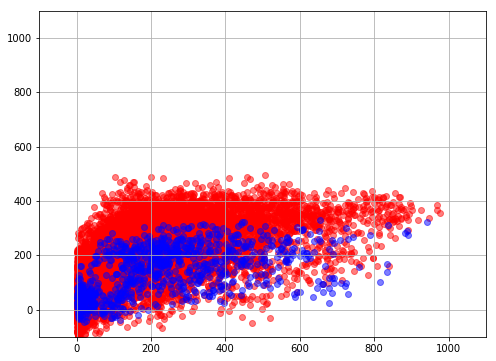

In [157]:
plt.figure(figsize=(8, 6))
plt.grid()
plt.xlim(-100, 1100)
plt.ylim(-100, 1100)
plt.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color='red')
plt.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color='blue')

Генеральное направление не диагональное, да и график очень похож на предыдущий, поэтому модель тоже плохая.     

Можно добавить признаки, в обучающей выборке которых будет прослеживаться линейная зависимость - это поможет улучшить прогноз для существующей модели.

А можно воспользоваться другой моделью, которая умеет учитывать нелинейные модели.

# Random Forest

In [159]:
from sklearn.ensemble import RandomForestRegressor

In [160]:
regressor = RandomForestRegressor(random_state=0, max_depth=20, n_estimators=50)

In [162]:
# Делаем ту же цепочку, что и в линейной модели, но заменим ее название в коде на "Случайный лес"

estimator = Pipeline(steps = [       
    ('feature_processing', FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', Pipeline(steps = [
                ('selecting', FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', Pipeline(steps = [
                ('selecting', FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [163]:
# Обучим модель
estimator.fit(train_data, train_labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x1203aff28>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          valida..._estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [164]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

79.477281539788123

Теперь ошибаемся в среднем на 80 велосипедов.

In [167]:
# Выведем предсказания и правильные значения целевой функции
print(test_labels[:10])
print('\n')
print(estimator.predict(test_data)[:10])

[525 835 355 222 228 325 328 308 346 446]


[ 409.565       505.56        256.06066667  165.6502619   205.82474784
  265.91960439  254.49615818  317.85774486  280.98963263  441.59333333]


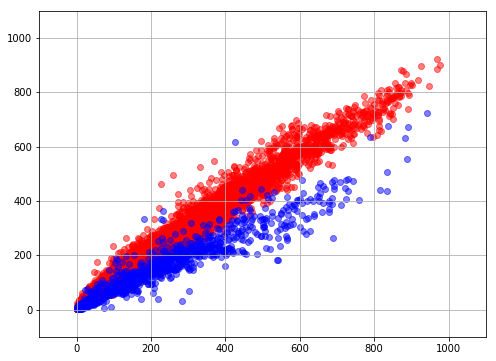

In [169]:
plt.figure(figsize=(8, 6))
plt.grid()
plt.xlim(-100, 1100)
plt.ylim(-100, 1100)
plt.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color='red')
plt.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color='blue')

**Объекты близко подошли к диагональной области --> модель прогнозируется гораздо лучше.**